In [2]:
from PIL import Image
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
Image.MAX_IMAGE_PIXELS = None
import metrics
from metrics import Metrics
import importlib
import glob

In [ ]:
mask = "/nfs2/baos1/rudravg/Retention_Masks/GCA071ACB_TISSUE03_TISSUE_RETENTION.tif"
default_img = "/nfs2/baos1/rudravg/GCA062ACA_TISSUE02_DAPI_DAPI_12ms_ROUND_01_initial_reg.tif"
default_dice_img = "/nfs2/baos1/rudravg/DeepCell_Results/GCA062ACA_TISSUE02_DAPI_DAPI_12ms_ROUND_01_initial_reg.tif"
default_img = np.array(Image.open(default_img))
mask = np.array(Image.open(mask))
mask = (mask > 0).astype(int)
default_img_masked = default_img * mask
new_img= "/nfs2/baos1/rudravg/GCA062ACA_TISSUE02_DAPI_DAPI_12ms_ROUND_01_initial_reg.tif"
new_img = np.array(Image.open(new_img))
new_img_masked = new_img * mask
#plot the images
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(default_img_masked)
ax[0].set_title("Default Image")
ax[1].imshow(new_img_masked)
ax[1].set_title("New Image")
ax[2].imshow(mask)
ax[2].set_title("Mask")
plt.show()

#calculate the metrics
m = Metrics(default_img_masked, new_img_masked)
m.calculate_ssim()



***Create Masks***

orig (772, 1677)
white (772, 1677)


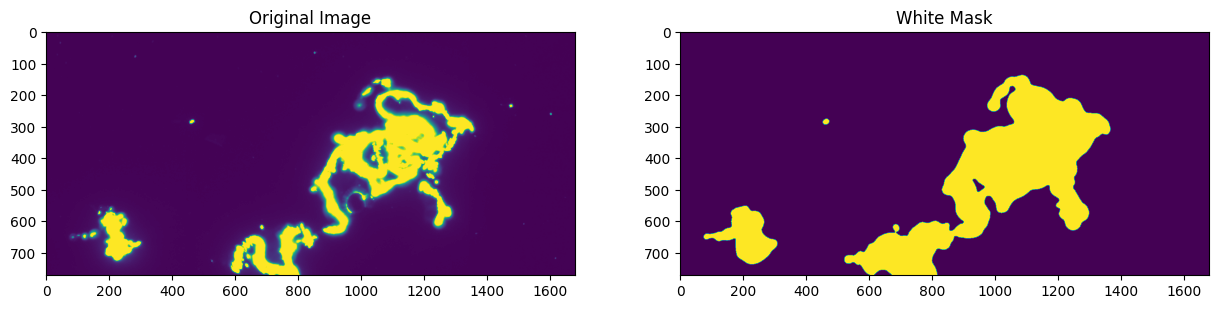

In [18]:
data_dir = "/nfs2/baos1/rudravg/TISSUE_MASK/GCA035ACB_TISSUE01_TISSUE_RETENTION.tif"
save_dir = "/nfs2/baos1/rudravg/Retention_Masks/"
orig = "/nfs2/baos1/rudravg/GCA035ACB_TISSUE01_DAPI_DAPI_12ms_ROUND_00_initial_reg.tif"
Image.MAX_IMAGE_PIXELS = None
orig_img = np.array(Image.open(orig))
retention_img = Image.open(data_dir)
retention_img = retention_img.resize(((retention_img.width // 2) +1, (retention_img.height // 2)+1))
pixels = np.array(retention_img)
num_white = 0
for pixel in pixels:
    if np.all(pixel == [0, 255, 0]):
        break
    else:
        num_white += 1

white_mask_exact = (pixels[:, :, 0] == 255) & (pixels[:, :, 1] == 255) & (pixels[:, :, 2] == 255)
white_mask = white_mask_exact[num_white-1:, :]
white_mask = white_mask[:orig_img.shape[0], :orig_img.shape[1]]

binary_mask_img_path = save_dir + "GCA062ACA_TISSUE03_TISSUE_RETENTION.tif"
binary_mask_img = Image.fromarray(white_mask.astype(np.uint8) * 255)
binary_mask_img.save(binary_mask_img_path)
#Print shape of orig_img and white_mask
print(f"orig {orig_img.shape}")
print(f"white {white_mask.shape}")

#Show both images
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(orig_img)
ax[0].set_title("Original Image")
ax[1].imshow(white_mask)
ax[1].set_title("White Mask")
plt.show()

In [ ]:
data_dir='/nfs2/baos1/rudravg/'
save_dir='/nfs2/baos1/rudravg/Retention_Masks/'
for file in tqdm(orig_files,desc="Processing files"):
    prefix = file.split('/')[-1].split('.')[0].split('_TISSUE_RETENTION')[0]

    data_dir2=data_dir+prefix+'_*.tif'
    data_files=glob.glob(data_dir2)
    file_check=data_files[0]
    orig_file_check=file
    retention_img = Image.open(orig_file_check)
    file_check=np.array(Image.open(file_check))
    retention_img = retention_img.resize(((retention_img.width // 2)+1 , (retention_img.height // 2)+1))
    pixels = np.array(retention_img)
    num_white = 0
    # Iterate over pixels in the middle column
    for pixel in pixels[:, 0]:
        if np.all(pixel == 0):
            break
        else:
            num_white += 1

    white_mask_exact = (pixels[:, :, 0] == 255) & (pixels[:, :, 1] == 255) & (pixels[:, :, 2] == 255)
    white_mask = white_mask_exact[num_white-1:, :]
    #Reshape the binary mask to match the size of the original image
    white_mask = white_mask[:file_check.shape[0], :file_check.shape[1]]
    binary_mask_img_path = save_dir + prefix + "_TISSUE_RETENTION.tif"
    binary_mask_img = Image.fromarray(white_mask.astype(np.uint8) * 255)
    binary_mask_img.save(binary_mask_img_path)


In [20]:
directory = '/nfs2/baos1/rudravg'
orig = f"{directory}/GCA033ACB_TISSUE02_*.tif"
mask= f"{directory}/Retention_Masks/GCA033ACB_TISSUE02_TISSUE_RETENTION.tif"
dice_img= f"{directory}/DeepCell_Results/GCA033ACB_TISSUE02_DAPI_DAPI*.tif"

orig_files = glob.glob(orig)
orig_files.sort(key=lambda x: int(x.split('/')[-1].split('_')[-3]))
default_img = orig_files[0]
default_img = np.array(Image.open(default_img))

dice_files= glob.glob(dice_img)
dice_files.sort(key=lambda x: int(x.split('/')[-1].split('_')[-3]))
default_dice_img = dice_files[0]
default_dice_img = np.array(Image.open(default_dice_img))

mask = np.array(Image.open(mask))
mask = (mask > 0).astype(int)

default_img = default_img * mask
default_dice_img = default_dice_img * mask

metric_sm=[]
metric_nmi=[]
metric_dice=[]
for file in tqdm(orig_files, desc="Calculating sm and nmi metrics"):
    new_img = file
    new_img = np.array(Image.open(new_img))
    new_img = new_img * mask
    m = Metrics(default_img, new_img)
    metric_sm.append(m.calculate_ssim())
    metric_nmi.append(m.calculate_normalized_mutual_information())
for file in tqdm(dice_files,desc="Calculating dice metric"):
    new_dice_img = file
    new_dice_img = np.array(Image.open(new_dice_img))
    new_dice_img = new_dice_img * mask
    m = Metrics(default_dice_img, new_dice_img)
    metric_dice.append(m.calculate_dice())
metric_sm, metric_nmi, metric_dice


Calculating dice metric: 100%|██████████| 18/18 [00:00<00:00, 57.70it/s]


([1.0,
  0.8628518735084314,
  0.9998422039126925,
  0.8375163048175501,
  0.8398507072893174,
  0.8357432744418802,
  0.8356972707753048,
  0.8318158414932075,
  0.8318360936511772,
  0.8316871064054858,
  0.8381099381412672,
  0.8349642650873365,
  0.8352629332729158,
  0.8356594108547766,
  0.8350033111430651,
  0.8353836701396548,
  0.8365256212244346,
  0.8373267756928614],
 [1.0,
  0.45306419190384534,
  0.9934701172671825,
  0.11144925350216933,
  0.08014660237179774,
  0.009472839948987994,
  0.008818179906408765,
  0.004036940067024224,
  0.0034726231576571696,
  0.004108319965477363,
  0.07059639797998911,
  0.004216676018644445,
  0.005586996460010247,
  0.005830786560879202,
  0.006338280021684019,
  0.004929227352319876,
  0.0736769834843768,
  0.1063299227429353],
 [1.0,
  0.5805376695463269,
  0.9994201876421981,
  0.11536665109761794,
  0.11701491778051913,
  0.0033573855713647503,
  0.00088044862243654,
  0.00028476506881822496,
  0.0,
  0.0,
  0.11473103013093548,
  0

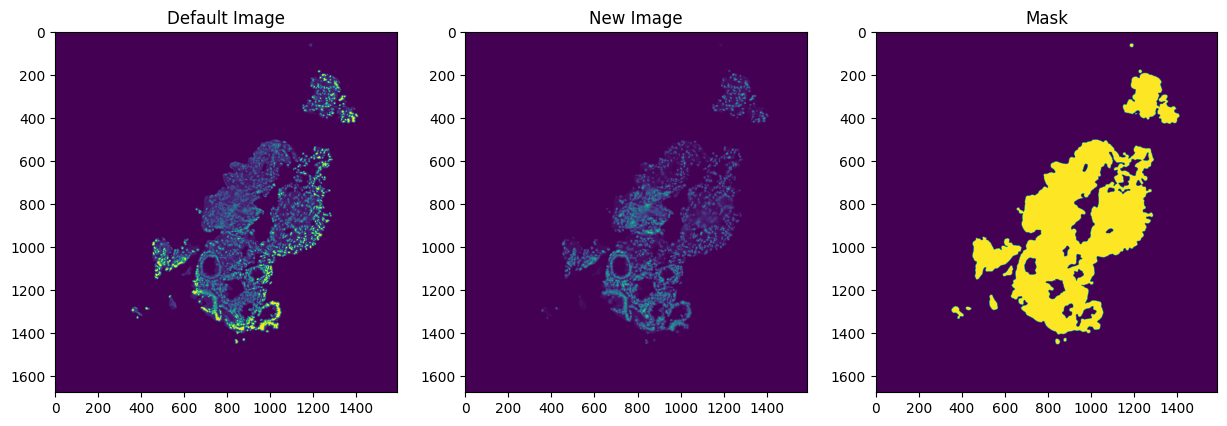

In [5]:
#Display the default_img and new_img and mask
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(default_img)
ax[0].set_title("Default Image")
ax[1].imshow(new_img)
ax[1].set_title("New Image")
ax[2].imshow(mask)
ax[2].set_title("Mask")
plt.show()

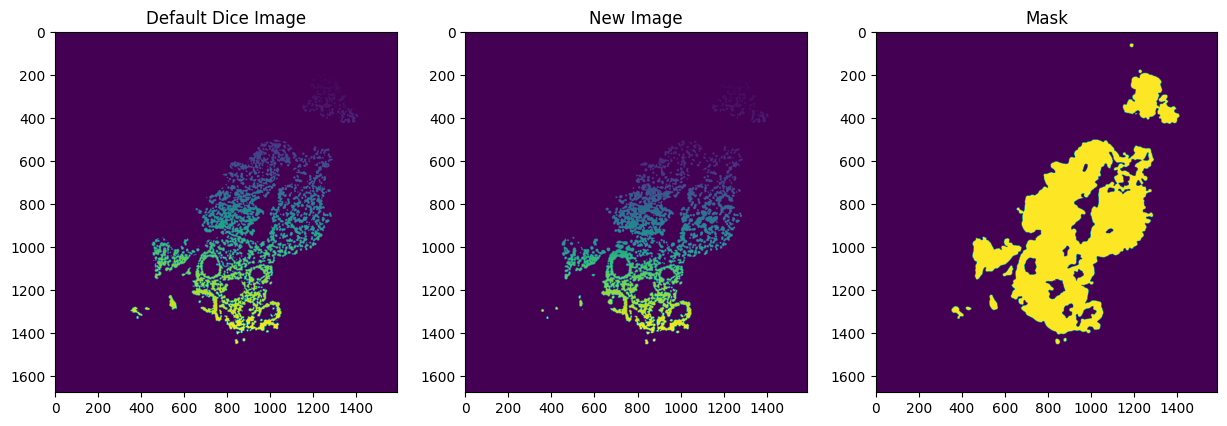

In [6]:
#Display the defk
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(default_dice_img)
ax[0].set_title("Default Dice Image")
ax[1].imshow(new_dice_img)
ax[1].set_title("New Image")
ax[2].imshow(mask)
ax[2].set_title("Mask")
plt.show()

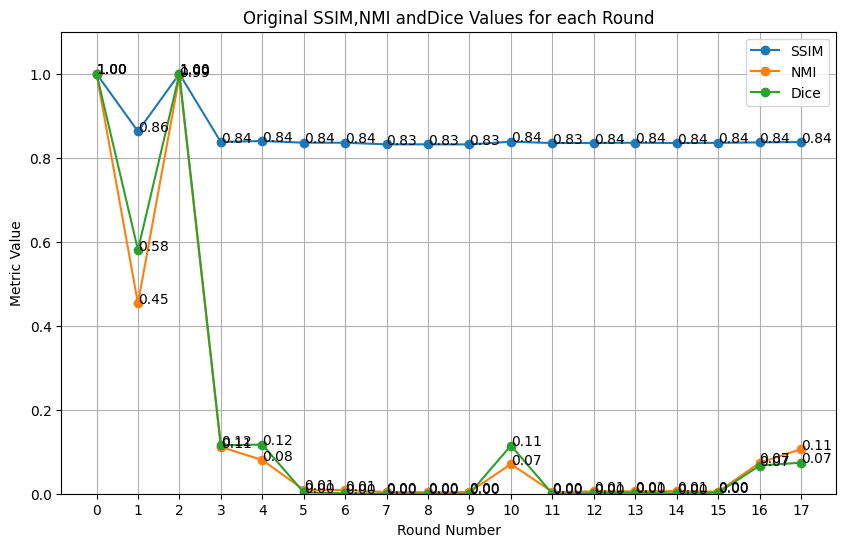

In [21]:
x= range(len(metric_sm))

plt.figure(figsize=(10, 6))
plt.plot(x, metric_sm, marker='o', label='SSIM')  # 'o' marker to show each point
plt.plot(x, metric_nmi, marker='o', label='NMI')  # 'o' marker to show each point
plt.plot(x, metric_dice, marker='o', label='Dice')  # 'o' marker to show each point

# Adding titles and labels
plt.title('Original SSIM,NMI andDice Values for each Round')
plt.xlabel('Round Number')
plt.ylabel('Metric Value')


# Adding y-values on each point for SSIM
for i, txt in enumerate(metric_sm):
    plt.annotate(f"{txt:.2f}", (x[i], metric_sm[i]))

# Adding y-values on each point for NMI
for i, txt in enumerate(metric_nmi):
    plt.annotate(f"{txt:.2f}", (x[i], metric_nmi[i]))

# Adding y-values on each point for Dice
for i, txt in enumerate(metric_dice):
    plt.annotate(f"{txt:.2f}", (x[i], metric_dice[i]))

plt.ylim(0, 1.1)  # Ensure y-axis ticks correspond to whole numbers
plt.grid(True)
plt.xticks(x)  # Ensure x-axis ticks correspond to whole numbers
plt.legend()  # Show legend
plt.show()

***Calclating Metrics after registration***

In [3]:
directory = '/nfs2/baos1/rudravg'
name='GCA112TIA'
mask= f"{directory}/Retention_Masks/"+name+"_TISSUE_RETENTION.tif"
dice_img= f"{directory}/registration/registration_"+name+"/affine/DeepCell_Results/"+name+"_DAPI_DAPI*.tif"
default_dice_img = f"{directory}/DeepCell_Results/"+name+"_DAPI_DAPI_30ms_ROUND_00_initial_reg.tif"

default_dice_img = np.array(Image.open(default_dice_img))

mask = np.array(Image.open(mask))
mask = (mask > 0).astype(int)

dice_files= glob.glob(dice_img)
dice_files.sort(key=lambda x: int(x.split('/')[-1].split('_')[-3]))

default_dice_img = default_dice_img * mask

metric_dice=[1]
for file in tqdm(dice_files,desc="Calculating dice metric"):
    new_dice_img = file
    new_dice_img = np.array(Image.open(new_dice_img))
    new_dice_img = new_dice_img * mask
    m = Metrics(default_dice_img, new_dice_img)
    metric_dice.append(m.overlap_coefficient())
metric_dice


Calculating dice metric: 100%|██████████| 19/19 [00:00<00:00, 25.61it/s]


[1,
 1.7691677140827367,
 1.8589103229684683,
 1.6977218633117988,
 1.690379280986515,
 1.7109908983631075,
 1.6631014873140857,
 1.6536139793486895,
 1.6722152516380873,
 1.7459693529055456,
 1.6192685057731349,
 1.614251899512208,
 1.614146827869874,
 1.579544720223234,
 1.6260514206648002,
 1.612052591331804,
 1.5468927121549707,
 1.5482376086124925,
 1.0684006399093264,
 1.540914794864348]

In [4]:
directory = '/nfs2/baos1/rudravg'
name='GCA112TIA'
mask= f"{directory}/Retention_Masks/"+name+"_TISSUE_RETENTION.tif"
dice_img= f"{directory}/DeepCell_Results/"+name+"_DAPI_DAPI*.tif"
default_dice_img = f"{directory}/DeepCell_Results/"+name+"_DAPI_DAPI_30ms_ROUND_00_initial_reg.tif"

default_dice_img = np.array(Image.open(default_dice_img))

mask = np.array(Image.open(mask))
mask = (mask > 0).astype(int)

dice_files= glob.glob(dice_img)
dice_files.sort(key=lambda x: int(x.split('/')[-1].split('_')[-3]))

default_dice_img = default_dice_img * mask

metric_dice=[]
for file in tqdm(dice_files,desc="Calculating dice metric"):
    new_dice_img = file
    new_dice_img = np.array(Image.open(new_dice_img))
    new_dice_img = new_dice_img * mask
    m = Metrics(default_dice_img, new_dice_img)
    metric_dice.append(m.overlap_coefficient())
metric_dice

Calculating dice metric:   0%|          | 0/20 [00:00<?, ?it/s]

Calculating dice metric: 100%|██████████| 20/20 [00:00<00:00, 32.99it/s]


[2.0,
 1.8656975791026833,
 1.8883654844527022,
 1.8001572062208748,
 1.7453824152482846,
 1.786848313909141,
 1.7485069378551255,
 1.7361174981122862,
 1.7538206131174383,
 1.8309778729478943,
 1.6589897178000577,
 1.6242075305047596,
 1.6475650700363669,
 1.6221345584874798,
 1.6823448952203985,
 1.6559794846134601,
 1.5621729011750014,
 1.5912687191940698,
 1.5738699975852304,
 1.5544782369940593]